In [1]:
import sys
sys.path.append('../../')

from keras.callbacks import EarlyStopping

from src.hypermodels import *
from src.utils  import *
from src.dataset import *

question_id = 3

# Load the data

In [2]:
image_size = 224

# duel_results_path = f'../../data/duel_results/duels_question_{question_id}'
# image_file_dir = '../../data/Mapillary_data/Sample_web_green'
# 
# print(f'Dataset Seed:{dataset_seed}') # For reproducibility, seed is defined using the date and time (e.g. 2021-01-01 12:30:15 -> seed = 20210101123015)

# (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(duel_results_path, 
#                                                                        image_file_dir, 
#                                                                        img_size=image_size,
#                                                                        model_type='ranking',
#                                                                        shuffle=True, 
#                                                                        shuffle_seed=dataset_seed)

# Load from the saved numpy arrays
x1_train,x2_train = np.load('../../data/Q3_Datasets_rs2310101944/x_train.npy')
x1_val,x2_val = np.load('../../data/Q3_Datasets_rs2310101944/x_val.npy')
x1_test,x2_test = np.load('../../data/Q3_Datasets_rs2310101944/x_test.npy')

y_train = np.load('../../data/Q3_Datasets_rs2310101944/y_train.npy')
y_val = np.load('../../data/Q3_Datasets_rs2310101944/y_val.npy')
y_test = np.load('../../data/Q3_Datasets_rs2310101944/y_test.npy')


x_train = [x1_train, x2_train]
x_val = [x1_val, x2_val]
x_test = [x1_test, x2_test]

del x1_train,x2_train,x1_val,x2_val,x1_test,x2_test

dataset_id = 'Q3_Datasets_rs2310101944'

# Data Preprocessing Hyperparameters (Using Keras Preprocessing Layers)

In [3]:
hps_data_preprocessing = {
    'image_preprocessing': {
        'resize': {'height': image_size, 'width': image_size, 'interpolation': 'bicubic'},
        'rescale': {'scale': 1.0 / 255},
    },
    'image_augmentation': {
        'random_rotation': {'factor': 0.4},
        'random_flip': {'mode': 'horizontal_and_vertical'},
        'random_contrast': {'factor': 0.7},
        'random_brightness': {'factor': 0.4, 'value_range': [0.0, 1.0]},
        'random_zoom': {'height_factor': 0.2, 'width_factor': 0.2},
    },
}

image_preprocessing_layers = Sequential(
    [
        layers.Resizing(height=hps_data_preprocessing['image_preprocessing']['resize']['height'],
                     width=hps_data_preprocessing['image_preprocessing']['resize']['width'], 
                     interpolation=hps_data_preprocessing['image_preprocessing']['resize']['interpolation']
                     ),
        layers.Rescaling(scale=hps_data_preprocessing['image_preprocessing']['rescale']['scale'])
    ],
    name='image_preprocessing'
)

image_augmentation_layers = Sequential(
    [
        layers.RandomRotation(factor=hps_data_preprocessing['image_augmentation']['random_rotation']['factor']),
        layers.RandomFlip(mode=hps_data_preprocessing['image_augmentation']['random_flip']['mode']),
        layers.RandomContrast(factor=hps_data_preprocessing['image_augmentation']['random_contrast']['factor']),
        layers.RandomBrightness(factor=hps_data_preprocessing['image_augmentation']['random_brightness']['factor'],
                                value_range=hps_data_preprocessing['image_augmentation']['random_brightness']['value_range']),
        layers.RandomZoom(height_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['height_factor'],
                          width_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['width_factor'])
    ],
    name='image_augmentation'
)

# Model Training Hyperparameters

In [4]:
hps_model_training = {'optimizer': 'adam',
                      'learning_rate': 0.0001,
                      'loss': 'binary_crossentropy',
                      'metrics': ['accuracy'],
                      'batch_size': 64,
                      'epochs': 30,
                      }

# Model Architecture Hyperparameters

In [5]:
hp_model_architecture = {
    'feature_extractor': 'vgg19',
    'num_dense_layers': 2,
    'dense_units': [32,64],
    'dense_dropout_rates': [0.5, 0.5],
    'dense_activation': ['relu', 'relu'],
    'ranking_score_activation': 'linear',
    'final_activation': 'sigmoid',
}

# Train the model

In [6]:
meta_model = create_siamese_network(img_size=image_size,
                                    image_preprocessing_layers=image_preprocessing_layers,
                                    image_augmentation_layers=image_augmentation_layers,
                                    feature_extractor=hp_model_architecture['feature_extractor'],
                                    num_dense_layers=hp_model_architecture['num_dense_layers'], 
                                    dense_units_list=hp_model_architecture['dense_units'],
                                    dense_activation_list=hp_model_architecture['dense_activation'],
                                    dropout_rate_list=hp_model_architecture['dense_dropout_rates'],
                                    ranking_score_activation=hp_model_architecture['ranking_score_activation'],
                                    final_activation=hp_model_architecture['final_activation'],
                                    unfreeze_layers = 4, # Fine-tune the last 4 layers of the VGG19
                                    pretrained_weights = 'imagenet' # Use the pre-trained weights of the VGG19
                                    )

meta_model.compile(optimizer=hps_model_training['optimizer'],
                   loss=hps_model_training['loss'],
                   metrics=hps_model_training['metrics'])

history = meta_model.fit(
    x=x_train,
    y=y_train,
    batch_size=hps_model_training['batch_size'],
    epochs=hps_model_training['epochs'],
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_accuracy',
                             patience=8,
                             verbose=1,
                             restore_best_weights=True)],
    verbose=1,
)


Epoch 1/30
33/33 [==============================] - 11s 245ms/step - loss: 0.9353 - accuracy: 0.6065 - val_loss: 0.5769 - val_accuracy: 0.6950
Epoch 2/30
33/33 [==============================] - 5s 163ms/step - loss: 0.7828 - accuracy: 0.6488 - val_loss: 0.5803 - val_accuracy: 0.6906
Epoch 3/30
33/33 [==============================] - 5s 164ms/step - loss: 0.7024 - accuracy: 0.6713 - val_loss: 0.6442 - val_accuracy: 0.7353
Epoch 4/30
33/33 [==============================] - 5s 163ms/step - loss: 0.6897 - accuracy: 0.6900 - val_loss: 0.5153 - val_accuracy: 0.7338
Epoch 5/30
33/33 [==============================] - 5s 163ms/step - loss: 0.7137 - accuracy: 0.6660 - val_loss: 0.6764 - val_accuracy: 0.6144
Epoch 6/30
33/33 [==============================] - 5s 163ms/step - loss: 0.8478 - accuracy: 0.5557 - val_loss: 0.6326 - val_accuracy: 0.6518
Epoch 7/30
33/33 [==============================] - 5s 163ms/step - loss: 0.7699 - accuracy: 0.5667 - val_loss: 0.5684 - val_accuracy: 0.7151
Epoch

# Save the model and the training results

Hyperparams saved!
Model history saved to csv!
Model architecture saved!
Model weights saved!
Model saved to keras!
Figure Training and ValidationLoss saved!


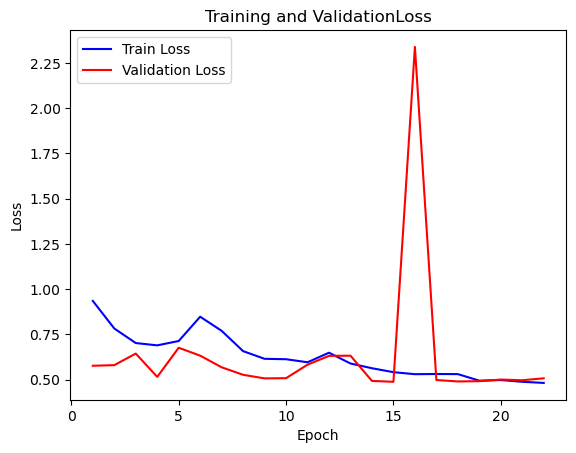

Figure Training and ValidationAccuracy saved!


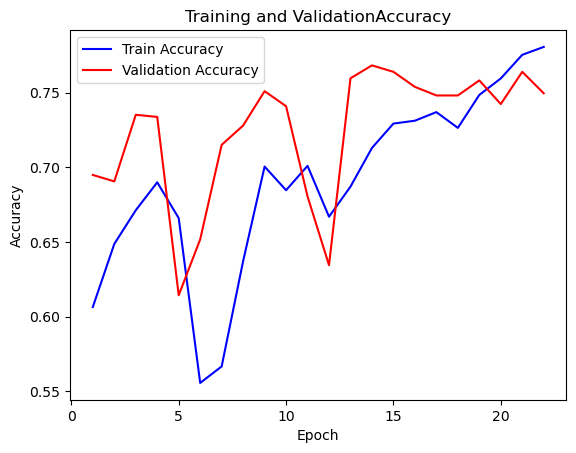

In [7]:
# Save the training results of meta_model
from src.utils import safe_save_training_results

best_val_acc = max(history.history['val_accuracy'])
model_save_dir = 'baseline_models/Ranking_VGG19_BestValAcc{:.4f}_{}'.format(best_val_acc,dataset_id)

safe_save_training_results(hyperparams_dict={'model_architecture': hp_model_architecture,
                                             'model_training': hps_model_training,
                                             'data_preprocessing': hps_data_preprocessing},
                           model=meta_model,
                           model_save_type='keras', 
                           history=history, 
                           his_save_type='csv', 
                           save_dir = model_save_dir,)

# Save the plot
plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)